In [1]:
from pathlib import Path
from xml.etree import ElementTree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision as tv
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import cv2

In [2]:
import warnings
warnings.filterwarnings('ignore')

Детекция фруктов.

Датасет: https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

Модель: Faster RCNN

In [3]:
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Загрузим и разархивируем датасет

In [4]:
import gdown
gdown.download('https://drive.google.com/uc?id=1itp1MtwVuF5xFnJkbErNQuDwKjEdmPvM',
               '34662_46346_bundle_archive.zip', quiet=True)

'34662_46346_bundle_archive.zip'

In [5]:
!unzip -q 34662_46346_bundle_archive.zip

In [6]:
device = (torch.device('cuda') if torch.cuda.is_available() else 
          torch.device('cpu'))

Закодируем классы и модифицируем модель, изменив количество предсказанных классов на нужное нам.

In [7]:
label_code = ['__background__', 'apple', 'orange', 'banana']

In [8]:
for param in model.parameters():
    param.requires_grad = False
num_class = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_class)

Предобработаем датасет.

In [9]:
# Предобработка датасета
class FrutDataset (torch.utils.data.Dataset):
    
    def __init__(self, path, mode):
        self.path = path 
        self.mode = mode
        path = Path(path)
        if mode == "train":
            _path = path /'train_zip'/'train'
            self.img_list = list(sorted(_path.glob("*.jpg")))
            self.xml_list = list(sorted(_path.glob("*.xml")))
        elif mode == "test":
            _path = path/'test_zip'/'test'
            self.img_list = list(sorted(_path.glob("*.jpg")))
            self.xml_list = list(sorted(_path.glob("*.xml")))
        else:
            raise ValueError('Incorrect mode')
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img = self.img_list[index]
        label = self.xml_list[index]
        pil_img = Image.open(img).convert('RGB')
        if self.mode == "train":
            rndlist = [tv.transforms.ColorJitter(brightness=(0, 1),
                                                 contrast=(0, 1),
                                                 saturation=(0, 1)
                                                 ),
                        tv.transforms.RandomGrayscale(p=0.1)
                        ]
            transform = tv.transforms.Compose([
                                            tv.transforms.RandomChoice(rndlist),
                                            tv.transforms.ToTensor()
                                            ])
            tensor_img = transform(pil_img)
        else:
            tensor_img = tv.transforms.ToTensor()(pil_img)
        # Извлечем координаты из xml  
        tr = ElementTree.parse(label)
        root = tr.getroot()
        name = []
        coord = []
        labels_code = ['__background__','apple', 'orange', 'banana']
        for element in root.iter('object'):
            temp_coord_list = []
            for child in element:
                if child.tag == 'name':
                    name += [labels_code.index(child.text)]
                elif child.tag == 'bndbox':
                    for number in child:
                        temp_coord_list +=[int(number.text)]
                    coord +=[temp_coord_list]
        coord = torch.LongTensor(coord)
        name = torch.LongTensor(name)
        label = {'boxes':coord , 'labels': name}
        return (tensor_img, label)

Создадим обучающий, валидационный датасеты, загрузчики и collate-функцию для приведения батча к требуемому виду.

In [10]:
train_set = FrutDataset(path='/content', mode='train')
val_set = FrutDataset(path='/content', mode='test')

In [11]:
def my_collate(batch):
    image = [img[0].to(device) for img in batch]
    target = [trgt[1] for trgt in batch]
    target = [{k: v.to(device) for k, v in t.items()} for t in target]
    return image, target

In [12]:
batch_size = 3
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           shuffle=True, collate_fn=my_collate)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, 
                                         shuffle=False, collate_fn=my_collate)

In [13]:
# Оптимизатор и sheduler
optim = torch.optim.AdamW(model.parameters(), amsgrad=True)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3, gamma=0.1)

Перенесем модель на GPU

In [ ]:
model.to(device)

In [15]:
def train_one_epoch(model, optimizer, train_set):
    model.train()
    epoch_loss = 0
    for images, targets in train_set:
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f'loss for {epoch} epoch {epoch_loss}')
    return epoch_loss

Реализуем метрику - IoU

![alt text](https://www.researchgate.net/publication/332181500/figure/fig2/AS:743652867469323@1554312068786/The-formula-with-which-the-Intersection-of-the-Union-IOU-was-calculated.ppm)


In [16]:
def iou (box_true, box_pred):
    '''
    box_true - [x1,y1,x2,y2]
    box_pred - [x1,y1,x2,y2]
    '''
    x1i = max(box_true[0],box_pred[0])
    y1i = max(box_true[1],box_pred[1])
    x2i = min(box_true[2],box_pred[2])
    y2i = min(box_true[3],box_pred[3])
    # Пересечение
    intersection = abs(y2i - y1i) * abs(x2i - x1i)
    box_true_area = (box_true[2] - box_true[0]) * (box_true[3] - box_true[1])
    box_pred_area = (box_pred[2] - box_pred[0]) * (box_pred[3] - box_pred[1])
    # Объединение
    union = box_true_area + box_pred_area - intersection
    iou = intersection / (union + 0.000001)
    return iou.item()

Реализуем валидацию и подсчет метрик: IoU, precision, recall и F1-score.
В цикле итерируемся по set-у предсказанных классов, оставив только те предсказания, в точности которых модель уверена более чем на 50%.

1) Если модель уверена в предсказанном классе менее чем на 50%, значит детекции не произошло: +1 FN

2) Если предсказанного класса нет на картинке: кол-во боксов прибавляем к FN.

3) Сравниваем каждый ground_truth_box со всеми предсказанными боксами с помощью IoU и заносим в матрицу, где количество строк = кол-ву ground_truth_box`ов, а количество столбцов - количеству предсказанных боксов.

4) Максимальный IoU больший 0.5 в строке считаем TP.

5) Количество предсказанных боксов минус TP считаем FP.

6) Количество ground_truth_box`ов (кол-во строк в матрице) минус TP считаем FN

7) После подсчета TP, FP, FN по всем классам на всех картинках посчитаем precision, recall и F1-score.

$\large precision = \frac{TP}{TP + FP}$

$\large recall = \frac{TP}{TP + FN}$

$\large \ F_\beta = (1 + \beta^2) \cdot \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}$

In [17]:
def validation(model, val_loader):
    model.eval()
    frame = pd.DataFrame({'class_name': label_code[1:], 
                          'TP': 0, 
                          'FP': 0, 
                          'FN': 0
                          }
                         )
    with torch.no_grad():
        for image, y_true in val_loader:
            image = image[0].unsqueeze(0)
            y_pred = model(image)
            for class_ in torch.unique(y_pred[0]['labels']):
                # Отсечем предсказания, 
                # в точности которых модель уверена менее чем на 50%
                pred_boxes = y_pred[0]['boxes'][(y_pred[0]['labels'] == class_)&
                                                (y_pred[0]['scores'] > 0.5)
                                                ]
                true_boxes = y_true[0]['boxes'][y_true[0]['labels'] == class_]
                # Если модель уверена менее чем на 50% в ответе,
                # значит детекции не произошло
                if len(pred_boxes) == 0:
                    frame.at[class_.item() - 1, 'FN'] += 1
                    continue
                #Если нашла классы, которых нет на картинке
                if len(true_boxes) == 0:
                    frame.at[class_.item() - 1, 'FN'] += len(pred_boxes)
                    continue
                iou_matrix = []
                # Подсчет IoU
                for t_box in true_boxes:
                    t_box_iou = []
                    for p_box in pred_boxes:
                        t_box_iou.append(iou(t_box,p_box))
                    iou_matrix.append(t_box_iou)
                iou_matrix=torch.FloatTensor(iou_matrix)
                iou_matrix[iou_matrix > 1] = 0 
                # Максимальный iou>0.5 по строкам считаем TP
                TP = torch.sum(iou_matrix.max(-1, keepdim=True)[0] > 0.5).item()
                frame.at[class_.item() - 1, 'TP'] += TP
                # Количество FP
                FP = abs(TP - iou_matrix.shape[1])
                frame.at[class_.item() - 1, 'FP'] += FP
                # Если true box не задетектирован: FN
                FN = iou_matrix.shape[0] - TP
                frame.at[class_.item() - 1, 'FN'] += FN
        # Метрики
        frame['precision'] = frame['TP'] / (frame['TP'] + frame['FP'])
        frame['recall'] = frame['TP'] / (frame['TP'] + frame['FN'])
        frame['F1'] = 2 * ((frame['precision'] * frame['recall']) /
                          (frame['precision'] + frame['recall']))
    return frame

In [ ]:
# Обучим присоединенные к модели части.
path_for_save = '/content/drive/My Drive/Fruit_detection/model_params.pth'
num_epochs = 10
save_point = 0
loss_for_epoch = []
plot_apple = []
plot_orange = []
plot_banana = []
for epoch in range(num_epochs):
    total_loss = train_one_epoch(model, optim, train_loader)
    loss_for_epoch += [total_loss]
    val_metrics = validation(model, val_loader)
    print(val_metrics)
    plot_apple += [val_metrics.at[0, 'F1']]
    plot_orange += [val_metrics.at[1, 'F1']]
    plot_banana += [val_metrics.at[2, 'F1']]
    # if val_metrics.F1.sum() > save_point:
    #     torch.save(model.state_dict(), path_for_save)
    #     save_point = total_loss
    lr_scheduler.step()

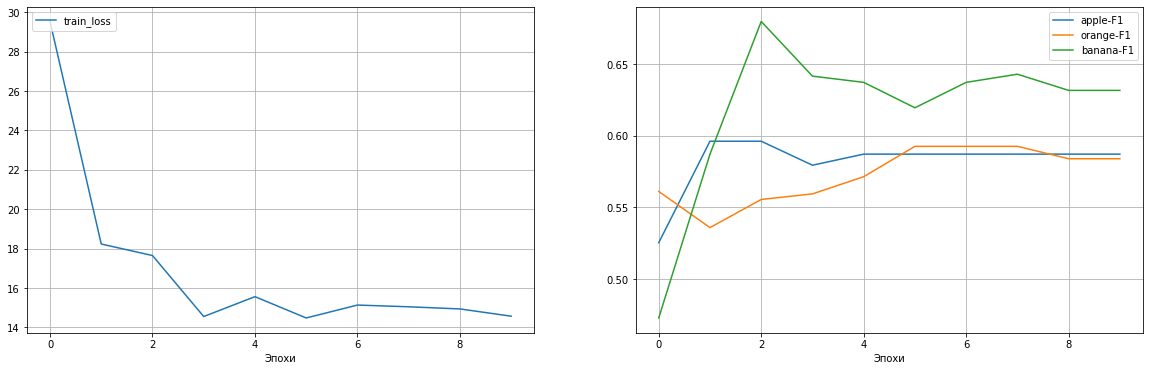

In [19]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(plot_apple)), plot_apple)
plt.plot(range(len(plot_orange)), plot_orange)
plt.plot(range(len(plot_banana)), plot_banana)
plt.legend(('apple-F1','orange-F1','banana-F1'))
plt.xlabel('Эпохи')
plt.grid(True)
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_for_epoch)), loss_for_epoch, label='train_loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.xlabel('Эпохи')
plt.show()

In [20]:
# Заморозим обученную часть и разморозим backbone.
for param in model.parameters():
    param.requires_grad = False
for param in model.backbone.parameters():
    param.requires_grad = True

In [ ]:
# Обучим backbone.
path_for_save = '/content/drive/My Drive/Fruit_detection/model_params.pth'
num_epochs = 15
save_point = 0
loss_for_epoch = []
plot_apple = []
plot_orange = []
plot_banana = []
for epoch in range(num_epochs):
    total_loss = train_one_epoch(model, optim, train_loader)
    loss_for_epoch += [total_loss]
    val_metrics = validation(model, val_loader)
    print(val_metrics)
    plot_apple += [val_metrics.at[0, 'F1']]
    plot_orange += [val_metrics.at[1, 'F1']]
    plot_banana += [val_metrics.at[2, 'F1']]
    # if val_metrics.F1.sum() > save_point:
    #     torch.save(model.state_dict(), path_for_save)
    #     save_point = total_loss
    lr_scheduler.step()

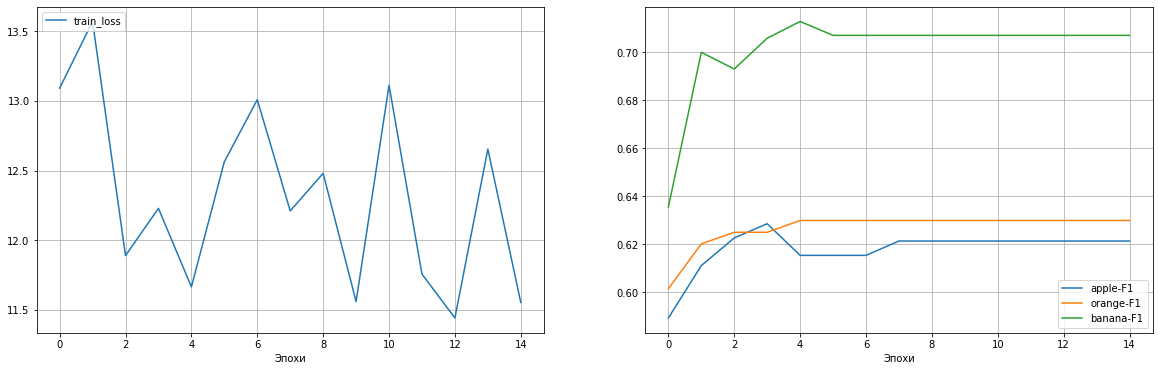

In [22]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(plot_apple)), plot_apple)
plt.plot(range(len(plot_orange)), plot_orange)
plt.plot(range(len(plot_banana)), plot_banana)
plt.legend(('apple-F1','orange-F1','banana-F1'))
plt.xlabel('Эпохи')
plt.grid(True)
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_for_epoch)), loss_for_epoch, label='train_loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.xlabel('Эпохи')
plt.show()

Если ранее уже обучали

In [ ]:
path_for_load = '/content/drive/My Drive/Fruit_detection/good_model_params.pth'
if Path(path_for_load).exists():
    model.load_state_dict(torch.load(path_for_load, map_location=device))

Проверим модель на изображении

--2020-07-25 16:23:12--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/800px-Apples.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227231 (222K) [image/jpeg]
Saving to: ‘800px-Apples.jpg’

800px-Apples.jpg    100%[===================>] 221.91K  --.-KB/s    in 0.05s   

2020-07-25 16:23:12 (4.74 MB/s) - ‘800px-Apples.jpg’ saved [227231/227231]



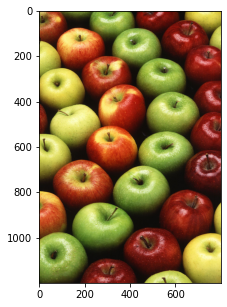

In [24]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/800px-Apples.jpg
pilimg = Image.open('/content/800px-Apples.jpg')
plt.figure(figsize=(10,5))
plt.imshow(pilimg);

In [25]:
def plot_preds(pilimg, predict):
    '''
    Функция отрисовывает предсказание модели
    '''
    numimg = np.array(pilimg)
    boxes = (predict[0]['boxes'][predict[0]['scores'] > 0.8].cpu()
                                                           .detach()
                                                           .numpy())
    labels = (predict[0]['labels'][predict[0]['scores'] > 0.8].cpu()
                                                             .detach()
                                                             .numpy())
    # Переведем метки в названия
    label_code = ['__background__', 'apple', 'orange', 'banana']
    # Отрисовка
    counter = 0
    for i in boxes:
        final = cv2.rectangle(numimg, (i[0],i[1]), (i[2],i[3]), 
                              color=(128, 0, 128), thickness=3)
        cv2.putText(numimg, str(label_code[labels[counter]]), (i[0],i[1]), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.6, (255,255,255), 2)
        counter += 1
    plt.figure(figsize=(15,10))
    return plt.imshow(final)

In [26]:
# Предскажем результат.
model.eval()
img = tv.transforms.ToTensor()(pilimg).unsqueeze(0)
img = img.to(device)
predict = model(img)

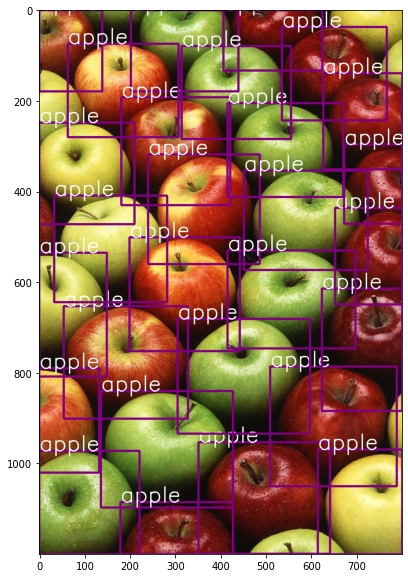

In [27]:
plot_preds(pilimg, predict);